In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [2]:
import pandas as pd
import numpy as np
import pandasql as ps
from datetime import timedelta  
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import pickle
sys.path.insert(1, r'./../functions')  # add to pythonpath
from detect_cusum import detect_cusum
from db_connection import get_postgres_data

In [3]:
pd.options.mode.chained_assignment = None

### Connect to postgresql Database and Load SQL Tables to Spark DataFrames

In [4]:
# Specify the driver location 
import os
jardrv = "/home/jovyan/.ivy2/jars/org.postgresql_postgresql-42.2.12.jar"

# create the SparkSession while pointing to the driver
import findspark 
findspark.init()
import pyspark 
from pyspark.sql import SparkSession
spark = SparkSession.builder\
                        .master("local") \
                        .appName("connect-to-db") \
                        .enableHiveSupport() \
                        .config("spark.driver.extraClassPath", jardrv) \
                        .getOrCreate()
spark

## Get measurements data + speed + myActivity for participant_id = 31 and kit_id = 57

In [19]:
df2 = get_postgres_data(url='jdbc:postgresql://193.55.95.225:32263/polluscopev5',kit_id=57,participant_id=31)

In [6]:
# test = df2.copy()
# test = df2.copy()
# test.index = range(len(test))
# test['truth'] = np.zeros(len(test))
# for i in range(len(test)):
#     if (test.activity.iloc[i] != test.activity.shift(1).iloc[i]) |\
#         (test.event.iloc[i] != test.event.shift(1).iloc[i]):
#         test.truth.iloc[i] = 1
        
# #test.drop(0, inplace=True)

# test = test[test.truth ==1]
# test = pd.DataFrame({'activity': test.activity, 'time': test.time - test.time.shift(1)})

# test.groupby('activity').max()

# print('median ', (test.time - test.time.shift(1)).median())
# print('min ', (test.time - test.time.shift(1)).min())
# print('max ', (test.time - test.time.shift(1)).max())
# print('mean ', (test.time - test.time.shift(1)).mean())

In [8]:
df2.head()

,participant_virtual_id,time,PM2.5,PM10,PM1.0,Temperature,Humidity,NO2,BC,vitesse(m/s),activity,event
0,9999915,2019-10-19 10:24:00,39.0,39.0,33.0,21.1,70.6,0.0,1603.0,0.0,Domicile,Cuisiner
1,9999915,2019-10-19 10:25:00,39.0,39.0,33.0,21.3,69.4,0.0,1816.0,0.0,Domicile,Cuisiner
2,9999915,2019-10-19 10:26:00,37.0,39.0,33.0,21.4,68.9,0.0,1645.0,0.0,Domicile,Cuisiner
3,9999915,2019-10-19 11:21:00,47.0,50.0,33.0,26.0,51.9,0.0,772.0,0.0,Domicile,Ouverture De Fenêtre
4,9999915,2019-10-19 11:22:00,34.0,38.0,24.0,26.1,51.8,0.0,500.0,0.0,Domicile,Ouverture De Fenêtre


In [9]:
df2.describe()

,PM2.5,PM10,PM1.0,Temperature,Humidity,NO2,BC,vitesse(m/s)
count,1261.000000,1261.000000,1261.000000,1260.000000,1260.000000,1261.000000,1256.000000,582.000000
mean,6.957177,7.831086,4.685170,26.587619,44.155794,7.114988,857.401274,1.612119
std,8.976057,9.908671,6.284903,3.908522,11.039431,7.622144,1455.798569,3.251611
min,0.000000,0.000000,0.000000,12.700000,33.300000,0.000000,-14616.000000,0.000000
25%,0.000000,0.000000,0.000000,26.700000,37.000000,2.000000,107.000000,0.000000
50%,5.000000,5.000000,3.000000,28.100000,41.400000,4.000000,579.500000,0.169665
75%,10.000000,11.000000,7.000000,28.800000,47.300000,10.000000,1047.000000,0.721483
max,90.000000,98.000000,64.000000,30.200000,90.800000,72.000000,24119.000000,17.517136


In [10]:
df2.dtypes

participant_virtual_id            object
time                      datetime64[ns]
PM2.5                            float64
PM10                             float64
PM1.0                            float64
Temperature                      float64
Humidity                         float64
NO2                              float64
BC                               float64
vitesse(m/s)                     float64
activity                          object
event                             object
dtype: object

## $Precision = \frac{TP}{TP + FP}$
  
## $Recall = \frac{TP}{TP + FN}$

In [11]:
def precision_recall(df):
    #TP = sum(x is not None for x in df[df.activity_time.notnull()].cusum_time.unique())
    #TP = sum(x is True for x in df[df.activity_time.notnull()].drop_duplicates('activity_time', keep='last').drop_duplicates('cusum_time').cusum_time.notnull())
    TP = len(df[(df.activity_time.notnull()) & (df.cusum_time.notnull())].drop_duplicates('activity_time').drop_duplicates('cusum_time'))
    FN = len(df[df.cusum_time.isnull()]) + len(df[(df.duplicated('cusum_time')) & (df.cusum_time.notnull())])
    FP = len(df[df.activity_time.isnull()]) + len(df[(df.duplicated('activity_time')) & (df.activity_time.notnull())])
    #FP = df[df.activity_time.isnull()].cusum_time.count()
    #FN = len(df[df.cusum_time.isnull()]) + \
    #sum(x is True for x in df[df.cusum_time.notnull()].duplicated('cusum_time')) ### (+ duplicates in cusum_time)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return precision, recall

In [13]:
##### Ground truth table
url = 'jdbc:postgresql://193.55.95.225:32263/polluscopev5'
table = '''(select res."time", res."activity"
from (
select date_trunc('minute',"tabletActivityApp"."timestamp") AS "time",
 "tabletActivityApp"."activity",
 "kit"."id" as "kit_id", "participant"."id" as "participant_id"
from "tablet","tabletActivityApp","campaignParticipantKit","kit","participant"
where "tabletActivityApp"."tablet_id"="kit"."tablet_id"
and "kit"."id"="campaignParticipantKit"."kit_id"
and "campaignParticipantKit"."participant_id"="participant"."id"
and "tabletActivityApp"."timestamp"
between "campaignParticipantKit"."start_date" and "campaignParticipantKit"."end_date"
and "tabletActivityApp"."tablet_id"="tablet"."id"
and "kit"."id"=57 and "participant"."id"=31

UNION

select date_trunc('minute',"tabletEventApp"."timestamp") AS "time",
"tabletEventApp"."event",
"kit"."id" as "kit_id", "participant"."id" as "participant_id"
from "tablet","tabletEventApp","campaignParticipantKit","kit","participant"
where "tabletEventApp"."tablet_id"="kit"."tablet_id"
and "kit"."id"="campaignParticipantKit"."kit_id"
and "campaignParticipantKit"."participant_id"="participant"."id"
and "tabletEventApp"."timestamp"
between "campaignParticipantKit"."start_date" and "campaignParticipantKit"."end_date"
and "tabletEventApp"."tablet_id"="tablet"."id"
and "kit"."id"=57 and "participant"."id"=31) as res
Order by res."time") as ae'''
properties = {'user': 'docker', 'password': 'docker'}
df = spark.read.jdbc(url=url, table=table, properties=properties)
truth = df.toPandas()

truth['time'] = pd.to_datetime(truth['time'], format='%Y-%m-%d %H:%M:%S')
truth["start_time"] = truth.time - timedelta(minutes = 5)
truth["end_time"] = truth.time + timedelta(minutes = 5)

In [23]:
df_variable = df2.dropna(subset= ['Temperature'])
df_variable.index = range(len(df_variable))
threshold = [0.6, 0.7, 0.6, 0.6, 0.6, 0.5, 0.5, 0.4, 0.4, 0.3, 0.3, 1, 1.5, 2]
drift = [0, 0.05, 0.05, 0.02, 0.01, 0.02, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01]
prec=[]
rec=[]

In [45]:
truth.head()

,time,activity,start_time,end_time
0,2019-10-19 09:53:00,Domicile,2019-10-19 09:48:00,2019-10-19 09:58:00
1,2019-10-19 09:54:00,Cuisiner,2019-10-19 09:49:00,2019-10-19 09:59:00
2,2019-10-19 10:29:00,Allumage De Cheminée,2019-10-19 10:24:00,2019-10-19 10:34:00
3,2019-10-19 11:00:00,Ouverture De Fenêtre,2019-10-19 10:55:00,2019-10-19 11:05:00
4,2019-10-19 12:46:00,Ouverture De Fenêtre,2019-10-19 12:41:00,2019-10-19 12:51:00


In [49]:
def cusum_(df, df_truth, variable, threshold, drift, show):
    df_variable = df.dropna(subset= [variable])
    df_variable.index = range(len(df_variable))
    
    prec=[]
    rec=[]
    
    for i in range(len(threshold)):
        ta, tai, taf, amp = detect_cusum(df_variable[variable], threshold[i], drift[i], True, show)
        #
        df_variable['CUSUM'] = np.zeros(len(df_variable))
        for i in ta:
            df_variable.loc[i,"CUSUM"] = 1
        #
        ##Create a buffering interval of 5 minutes
        cusum = df_variable[df_variable.CUSUM == 1][["time", "activity", "event", "CUSUM"]]
        truth = df_truth
        
        sqlcode = '''
        select cusum.time as cusum_time,
        truth.time as activity_time, truth.activity                
        from truth
        left join cusum  
        on cusum.time between truth.start_time and truth.end_time
        
        UNION
        
        select cusum.time as cusum_time,
        truth.time as activity_time, truth.activity                
        from cusum
        left join truth 
        on cusum.time between truth.start_time and truth.end_time
        '''
        newdf = ps.sqldf(sqlcode,locals())
        #
        precision, recall = precision_recall(newdf)
        #
        prec.append(precision)
        rec.append(recall)
        
        #results = pd.DataFrame({'Threshold': threshold, 'Drift': drift, 'Precision': prec, 'Recall': rec})
    
    return df_variable, newdf, prec, rec

# Temperature

In [47]:
def test(df, truth, variable,threshold, drift, show):
    df_variable = df.dropna(subset= [variable])
    df_variable.index = range(len(df_variable))
    
    prec=[]
    rec=[]
    
    for i in range(len(threshold)):
        ta, tai, taf, amp = detect_cusum(df_variable[variable], threshold[i], drift[i], True, show)

        df_variable['CUSUM'] = np.zeros(len(df_variable))
        for i in ta:
            df_variable.loc[i,"CUSUM"] = 1

        cusum = df_variable[df_variable.CUSUM == 1][["time", "activity", "event", "CUSUM"]]
        truth = truth
    
        sqlcode = '''
        select cusum.time as cusum_time,
        truth.time as activity_time,
        truth.activity

        from truth
        left join cusum  
        on cusum.time between truth.start_time and truth.end_time

        UNION

        select cusum.time as cusum_time,
        truth.time as activity_time,
        truth.activity

        from cusum
        left join truth 
        on cusum.time between truth.start_time and truth.end_time
        '''
        newdf = ps.sqldf(sqlcode,locals())
    return precision_recall(newdf)

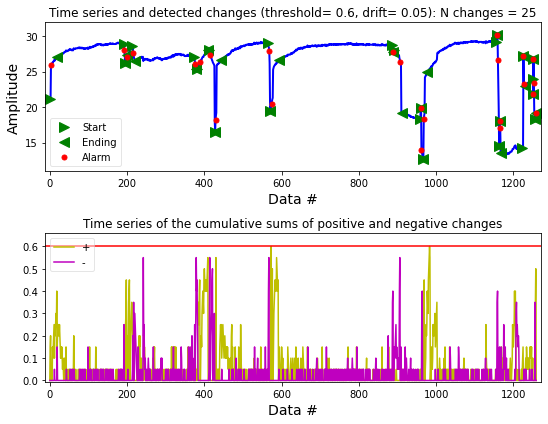

(0.35714285714285715, 0.13513513513513514)

In [48]:
test(df2, truth, 'Temperature',[.6], [0.05],True)

In [50]:
threshold = [0.6, 0.7, 0.6, 0.6, 0.6, 0.5, 0.5, 0.4, 0.4, 0.3, 0.3, 1, 1.5, 2]
drift = [0, 0.05, 0.05, 0.02, 0.01, 0.02, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01]
df_temperature, newdf_t, prec, rec = cusum_(df2, truth, 'Temperature', threshold, drift, False)
results = pd.DataFrame({'Threshold': threshold, 'Drift': drift, 'Precision': prec, 'Recall': rec})
results

,Threshold,Drift,Precision,Recall
0,0.6,0.00,0.071429,0.027027
1,0.7,0.05,0.344828,0.135135
2,0.6,0.05,0.357143,0.135135
3,0.6,0.02,0.303030,0.135135
4,0.6,0.01,0.344828,0.135135
5,0.5,0.02,0.294118,0.135135
6,0.5,0.01,0.263158,0.135135
7,0.4,0.01,0.244444,0.148649
8,0.4,0.02,0.256410,0.135135
9,0.3,0.02,0.255814,0.148649


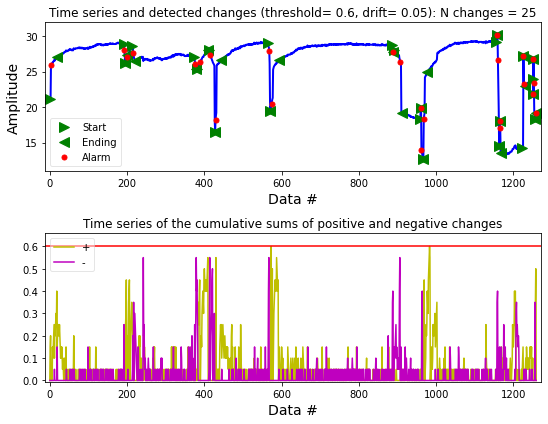

In [51]:
df_temperature, newdf_t, prec_t, rec_t = cusum_(df2, truth, 'Temperature', [0.6], [0.05], True)

In [52]:
prec_t, rec_t

([0.35714285714285715], [0.13513513513513514])

In [53]:
newdf_t

,cusum_time,activity_time,activity
0,None,2019-10-19 09:53:00.000000,Domicile
1,None,2019-10-19 09:54:00.000000,Cuisiner
2,None,2019-10-19 10:29:00.000000,Allumage De Cheminée
3,None,2019-10-19 11:00:00.000000,Ouverture De Fenêtre
4,None,2019-10-19 12:46:00.000000,Ouverture De Fenêtre
...,...,...,...
84,2019-10-23 16:27:00.000000,None,None
85,2019-10-23 17:03:00.000000,None,None
86,2019-10-24 11:16:00.000000,2019-10-24 11:14:00.000000,Vélo
87,2019-10-24 12:40:00.000000,None,None


# Humidity

In [1203]:
threshold_h = [4, 4, 4, 4, 3, 3, 5]
drift_h = [0.06, 0.5, 0.05, 0.02, 0.05, 0.02, 0.05]
df_humidity, newdf_h, prec_h, rec_h = cusum_(df2, truth, 'Humidity', threshold_h, drift_h, False)
results_h = pd.DataFrame({'Threshold': threshold_h, 'Drift': drift_h, 'Precision': prec_h, 'Recall': rec_h})
results_h

,Threshold,Drift,Precision,Recall
0,4,0.06,0.692308,0.782609
1,4,0.50,0.714286,0.652174
2,4,0.05,0.703704,0.826087
3,4,0.02,0.620690,0.782609
4,3,0.05,0.575758,0.826087
5,3,0.02,0.562500,0.782609
6,5,0.05,0.640000,0.695652


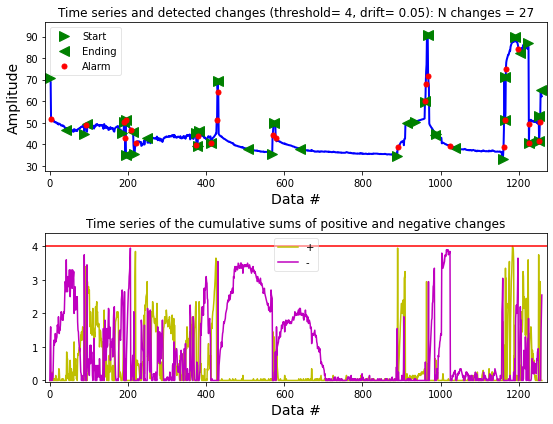

In [1204]:
df_humidity, newdf_h, prec_h, rec_h = cusum_(df2,truth, 'Humidity', [4], [0.05], True)

In [1205]:
prec_h, rec_h

([0.7037037037037037], [0.8260869565217391])

In [1258]:
newdf_h

,cusum_time,activity_time,activity,event
0,None,2019-10-19 10:24:00.000000,Domicile,Cuisiner
1,None,2019-10-20 17:16:00.000000,Domicile,Allumage De Cheminée
2,None,2019-10-21 11:02:00.000000,Vélo,Allumage De Cheminée
3,None,2019-10-23 17:03:00.000000,Vélo,Repos
4,2019-10-19 11:21:00.000000,2019-10-19 11:21:00.000000,Domicile,Ouverture De Fenêtre
5,2019-10-19 12:51:00.000000,2019-10-19 12:48:00.000000,Domicile,Fermeture De Fenêtre
6,2019-10-19 14:29:00.000000,2019-10-19 14:28:00.000000,Rue,Fermeture De Fenêtre
7,2019-10-19 14:31:00.000000,2019-10-19 14:28:00.000000,Rue,Fermeture De Fenêtre
8,2019-10-20 12:52:00.000000,2019-10-20 12:52:00.000000,Voiture,Fermeture De Fenêtre
9,2019-10-20 13:04:00.000000,None,None,None


# NO2

In [1206]:
threshold_NO2 = [15, 20, 15, 20, 15, 20, 20, 20, 15, 15]
drift_NO2 = [0, 3, 13, 10, 10, 5, 0, 15, 15, 12]
df_NO2, newdf_NO2, prec_NO2, rec_NO2 = cusum_(df2,truth, 'NO2', threshold_NO2, drift_NO2, False)
results_NO2 = pd.DataFrame({'Threshold': threshold_NO2, 'Drift': drift_NO2, 'Precision': prec_NO2, 'Recall': rec_NO2})
results_NO2.sort_values(['Threshold', 'Drift'])

,Threshold,Drift,Precision,Recall
0,15,0,0.275000,0.478261
4,15,10,0.500000,0.304348
9,15,12,0.538462,0.304348
2,15,13,0.636364,0.304348
8,15,15,0.666667,0.260870
6,20,0,0.296296,0.347826
1,20,3,0.380952,0.347826
5,20,5,0.500000,0.347826
3,20,10,0.666667,0.260870
7,20,15,0.571429,0.173913


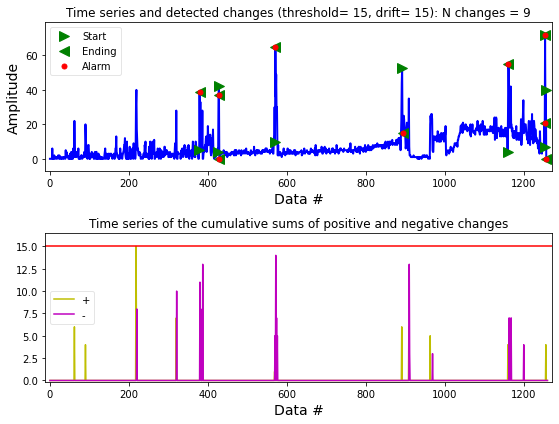

In [1207]:
df_NO2, newdf_NO2, prec_NO2, rec_NO2 = cusum_(df2,truth, 'NO2', [15], [15], True)

In [1208]:
prec_NO2, rec_NO2

([0.6666666666666666], [0.2608695652173913])

# BC

In [1209]:
threshold_BC = [15, 100, 200, 300, 500, 700, 800, 800, 1000, 900]
drift_BC = [0, 20, 20, 20, 200, 200, 200, 500, 500, 500]
df_BC, newdf_BC, prec_BC, rec_BC  = cusum_(df2, truth,'BC', threshold_BC, drift_BC, False)
results_BC = pd.DataFrame({'Threshold': threshold_BC, 'Drift': drift_BC, 'Precision': prec_BC, 'Recall': rec_BC})
results_BC.sort_values(['Threshold', 'Drift'])

,Threshold,Drift,Precision,Recall
0,15,0,0.031866,0.840000
1,100,20,0.067114,0.800000
2,200,20,0.077236,0.791667
3,300,20,0.092683,0.791667
4,500,200,0.191919,0.826087
5,700,200,0.188889,0.739130
6,800,200,0.186047,0.695652
7,800,500,0.205479,0.652174
9,900,500,0.220588,0.652174
8,1000,500,0.203125,0.565217


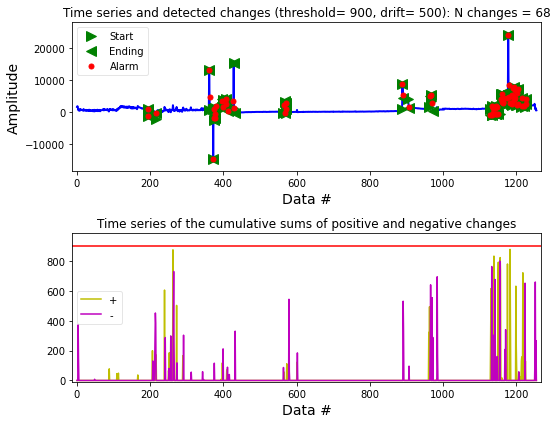

In [1210]:
df_BC, newdf_BC, prec_BC, rec_BC = cusum_(df2,truth, 'BC', [900], [500], True)

In [1211]:
prec_BC, rec_BC

([0.22058823529411764], [0.6521739130434783])

# PM2.5

In [1212]:
threshold_PM25 = [25]*11
drift_PM25 = np.linspace(0,0.1,11)
df_PM25, newdf_PM25, prec_PM25, rec_PM25  = cusum_(df2, truth, 'PM2.5', threshold_PM25, drift_PM25, False)
results_PM25 = pd.DataFrame({'Threshold': threshold_PM25, 'Drift': drift_PM25, 'Precision': prec_PM25, 'Recall': rec_PM25})
results_PM25.sort_values(['Threshold', 'Drift'])

,Threshold,Drift,Precision,Recall
0,25,0.00,0.666667,0.260870
1,25,0.01,0.777778,0.304348
2,25,0.02,0.875000,0.304348
3,25,0.03,0.875000,0.304348
4,25,0.04,0.857143,0.260870
5,25,0.05,0.857143,0.260870
6,25,0.06,0.857143,0.260870
7,25,0.07,0.857143,0.260870
8,25,0.08,0.857143,0.260870
9,25,0.09,0.857143,0.260870


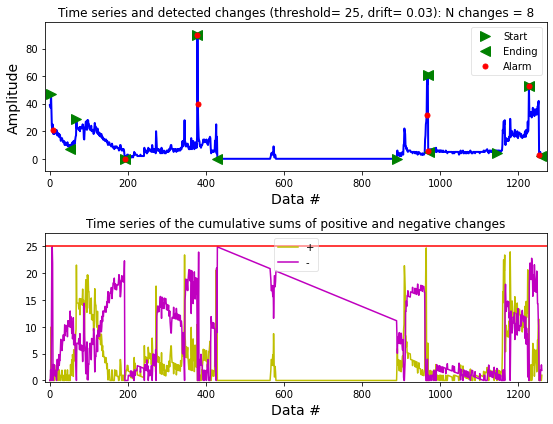

In [1213]:
df_PM25, newdf_PM25, prec_PM25, rec_PM25  = cusum_(df2,truth, 'PM2.5',  [25], [0.03], True)

In [1214]:
prec_PM25, rec_PM25

([0.875], [0.30434782608695654])

# Speed

In [1215]:
threshold_speed = [1.5]*10 + [1]*10 + [6]
drift_speed = np.append(np.append(np.linspace(0.1,1,10), np.linspace(0.1,1,10)), [0.1])
df_speed, newdf_speed, prec_speed, rec_speed  = cusum_(df2,truth, 'vitesse(m/s)', threshold_speed, drift_speed, False)
results_speed = pd.DataFrame({'Threshold': threshold_speed, 'Drift': drift_speed, 'Precision': prec_speed, 'Recall': rec_speed})
results_speed.sort_values(['Threshold', 'Drift'])

,Threshold,Drift,Precision,Recall
10,1.0,0.1,0.128571,0.529412
11,1.0,0.2,0.132353,0.529412
12,1.0,0.3,0.134328,0.529412
13,1.0,0.4,0.121212,0.470588
14,1.0,0.5,0.123077,0.470588
15,1.0,0.6,0.112903,0.411765
16,1.0,0.7,0.114754,0.411765
17,1.0,0.8,0.114754,0.411765
18,1.0,0.9,0.116667,0.411765
19,1.0,1.0,0.120690,0.411765


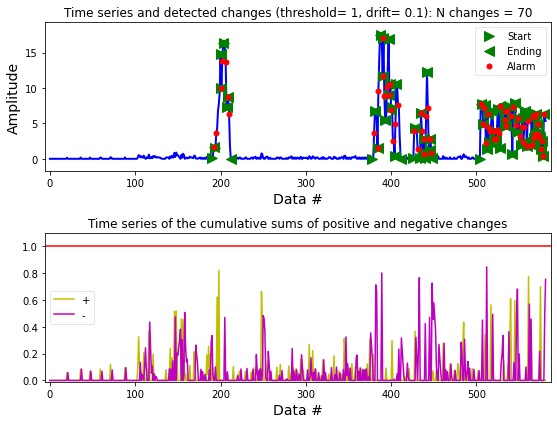

In [1216]:
df_speed, newdf_speed, prec_speed, rec_speed  = cusum_(df2,truth, 'vitesse(m/s)', [1], [0.1], True)

In [1217]:
prec_speed, rec_speed

([0.12857142857142856], [0.5294117647058824])

In [1259]:
newdf_speed

,cusum_time,activity_time,activity,event
0,None,2019-10-19 10:24:00.000000,Domicile,Cuisiner
1,None,2019-10-19 11:21:00.000000,Domicile,Ouverture De Fenêtre
2,None,2019-10-19 12:48:00.000000,Domicile,Fermeture De Fenêtre
3,None,2019-10-20 13:18:00.000000,Domicile,Fermeture De Fenêtre
4,None,2019-10-20 17:14:00.000000,Domicile,Fermeture De Fenêtre
...,...,...,...,...
73,2019-10-23 07:35:00.000000,None,None,None
74,2019-10-23 07:38:00.000000,None,None,None
75,2019-10-23 17:03:00.000000,None,None,None
76,2019-10-24 11:16:00.000000,2019-10-24 11:16:00.000000,Vélo,Allumage De Cheminée


# Join data into one table

In [1218]:
%run SQLcode.ipynb

In [1219]:
# dfnames = ['TH1', 'TH2', 'TH3', 'TH4', 'TH5', 'TH6', 'TH7']
# DFs = {x:pd.DataFrame() for x in dfnames}
TH1 = ps.sqldf(sqlcode1,locals())
TH2 = ps.sqldf(sqlcode2,locals())
TH3 = ps.sqldf(sqlcode3,locals())
TH4 = ps.sqldf(sqlcode4,locals())
TH5 = ps.sqldf(sqlcode5,locals())

In [1220]:
TH5.head()

,Speed,PM25,BC,NO2,temperature,humidity,activity_time,activity,event
0,None,None,None,None,None,None,2019-10-19 10:24:00.000000,Domicile,Cuisiner
1,None,None,None,None,None,2019-10-19 12:51:00.000000,2019-10-19 12:48:00.000000,Domicile,Fermeture De Fenêtre
2,None,None,None,None,None,2019-10-20 13:04:00.000000,None,None,None
3,None,None,None,None,None,2019-10-20 16:29:00.000000,None,None,None
4,None,None,None,None,None,2019-10-21 11:57:00.000000,None,None,None


In [1221]:
TH5[110:150]

,Speed,PM25,BC,NO2,temperature,humidity,activity_time,activity,event
110,2019-10-20 17:01:00.000000,None,None,None,None,None,None,None,None
111,2019-10-20 17:04:00.000000,None,None,None,None,None,None,None,None
112,2019-10-21 06:52:00.000000,None,2019-10-21 06:52:00.000000,2019-10-21 06:52:00.000000,None,2019-10-21 06:52:00.000000,2019-10-21 06:52:00.000000,Vélo,Allumage De Cheminée
113,2019-10-21 11:15:00.000000,None,2019-10-21 11:14:00.000000,2019-10-21 11:14:00.000000,2019-10-21 11:19:00.000000,2019-10-21 11:14:00.000000,2019-10-21 11:18:00.000000,Bureau,Allumage De Cheminée
114,2019-10-21 11:15:00.000000,None,2019-10-21 11:15:00.000000,2019-10-21 11:14:00.000000,2019-10-21 11:19:00.000000,2019-10-21 11:14:00.000000,2019-10-21 11:18:00.000000,Bureau,Allumage De Cheminée
115,2019-10-21 17:17:00.000000,None,None,None,None,None,2019-10-21 17:17:00.000000,Voiture,Allumage De Cheminée
116,2019-10-21 17:18:00.000000,None,None,None,None,None,2019-10-21 17:17:00.000000,Voiture,Allumage De Cheminée
117,2019-10-21 17:20:00.000000,None,None,None,None,None,2019-10-21 17:17:00.000000,Voiture,Allumage De Cheminée
118,2019-10-21 17:21:00.000000,None,None,None,None,None,2019-10-21 17:17:00.000000,Voiture,Allumage De Cheminée
119,2019-10-21 17:23:00.000000,None,None,None,None,None,None,None,None


# Post processing

In [1222]:
res = TH5.copy()
res.sort_values(['activity_time', 'humidity', 'temperature', 'NO2', 'BC', 'PM25', 'Speed'], inplace=True)

### Create a new column which takes only zeros
res['verification'] = np.zeros(len(res))

#### Define the format of the time columns
for i in res.drop(['activity', 'event', 'verification'], axis=1).columns:
    res[i] = pd.to_datetime(res[i], format='%Y-%m-%d %H:%M:%S')

In [1223]:
#res['verification'] = pd.to_datetime(res['verification'], format='%Y-%m-%d %H:%M:%S')

In [1224]:
#### Shape of the data frame when activity_time is not null before post-processing
res[res.activity_time.notnull()].shape

(43, 10)

In [1225]:
res.dtypes

Speed            datetime64[ns]
PM25             datetime64[ns]
BC               datetime64[ns]
NO2              datetime64[ns]
temperature      datetime64[ns]
humidity         datetime64[ns]
activity_time    datetime64[ns]
activity                 object
event                    object
verification            float64
dtype: object

In [1226]:
for i in range(len(res)):
    
    ##### If at least one of the time series return a true positive change detection, in other words, activity_time is not null 
    ##### and at least one of the time series column is not null, 
    #### the verification column get the closest change time to the actual change point time.
    if (res.iloc[i].drop(['activity_time', 'activity', 'event', 'verification']).notnull().any()) & (res.activity_time.notnull().iloc[i]):
        res['verification'].iloc[i] = res.activity_time.iloc[i] + \
        abs(res['activity_time'].loc[i] - res[res.drop(['activity_time', 'activity', 'event', 'verification'], axis=1).columns].loc[i]).min()
    
    #### else, if at least one column is not null and activity_time is null (the case of False Positive), we return the mean value
    elif (res.iloc[i].drop(['activity_time', 'activity', 'event', 'verification']).notnull().any()) & (res.activity_time.isnull().iloc[i]):
        res['verification'].iloc[i] = res[res.drop(['activity_time', 'activity', 'event', 'verification'], axis=1).columns].iloc[i].mean()

In [1227]:
#### Drop the first recorded timestamp, because it is not an actual change point, but the tablet just started recording.
res.drop(res[res.activity_time == df2.sort_values(['time']).time.iloc[0]].index, inplace = True)

In [1228]:
res.shape

(163, 10)

In [1229]:
### Drop the duplicated values
res.drop_duplicates('verification', inplace = True)

In [1230]:
res.shape

(115, 10)

## Performance

In [1231]:
TP = len(res[(res.activity_time.notnull()) & (res.verification != 0)])
FP = len(res[(res.activity_time.isnull()) & (res.verification != 0)])
FN = len(res[(res.activity_time.notnull()) & (res.verification == 0)])

In [1232]:
print( 'Precision: ', TP / (TP + FP))
print('Recall :', TP / (TP + FN))

Precision:  0.10434782608695652
Recall : 1.0


### All the points have been detected, but, many false positives have been detected also and need post processing as well.  

(With spark SQL it would probably be easier)

In [1234]:
res.sort_values(['verification'], inplace = True)
res['verification'] = pd.to_datetime(res['verification'], format='%Y-%m-%d %H:%M:%S')
for i in range(len(res)):
    if (res['verification'].iloc[i] - res.shift(1)['verification'].iloc[i] < timedelta(minutes=5)) & \
    ((res.activity_time.isnull().iloc[i]) | (res.activity_time.shift(1).isnull().iloc[i])):
        res['verification'].iloc[i] = res['verification'].shift(1).iloc[i]
        for j in res.drop(['activity_time', 'activity', 'event', 'verification'], axis=1).columns:
            if res[j].shift(1).isnull().iloc[i]:
                res[j].iloc[i-1] = res[j].iloc[i]        

In [1235]:
res = res.sort_values(['verification', 'activity_time']).drop_duplicates('verification', keep='first')

In [1236]:
res.shape

(49, 10)

In [1237]:
FP_ = len(res[(res.activity_time.isnull()) & (res.verification != 0)])

In [1238]:
print( 'Precision: ', TP / (TP + FP_))
print('Recall :', TP / (TP + FN))

Precision:  0.24489795918367346
Recall : 1.0


In [1239]:
# ### Export results to Grafana
# grafana = res.copy()
# grafana['flag'] = np.zeros(len(grafana))
# grafana = grafana.drop(['activity_time', 'activity', 'event', 'verification'], axis=1)

# for i in range(len(grafana)):
#     grafana['flag'].iloc[i] = grafana[['Speed', 'PM25', 'BC', 'NO2', 'temperature', 'humidity']].\
#     columns[(grafana[['Speed', 'PM25', 'BC', 'NO2', 'temperature', 'humidity']].notnull().iloc[i])].values
# grafana['kit_id'] = 57

# grafana.to_csv('grafana.csv', index=False)

In [1240]:
## Export results to grafana
# timestamp, flag =[], []
# for col in res.drop(['activity_time', 'activity', 'event', 'verification'], axis=1).columns:
#     timestamp.extend(res[res[col].notnull()][col])
#     flag.extend([col] * len(res[res[col].notnull()][col]))
    
# grafana = pd.DataFrame({'kit_id': [57]*len(timestamp), 'timestamp': timestamp, 'flag': flag})

# #grafana['timestamp'] = grafana.timestamp - timedelta(hours=2)
# grafana.to_csv('grafana.csv', index=False)

# Train a model which assigns different weights to each time series

In [1241]:
# Recode the detected change point by 1 and 0
data = pd.DataFrame({j : np.where(res[j].notnull(), 1, 0) for j in res.drop(['activity', 'event', 'verification'], axis=1).columns})

In [1242]:
res.drop(['activity', 'event', 'verification'], axis=1).head()

,Speed,PM25,BC,NO2,temperature,humidity,activity_time
78,NaT,2019-10-19 11:26:00,NaT,NaT,2019-10-19 11:21:00,2019-10-19 11:21:00,2019-10-19 11:21:00
84,2019-10-20 12:58:00,NaT,NaT,NaT,NaT,NaT,NaT
86,2019-10-20 13:03:00,NaT,NaT,NaT,NaT,2019-10-20 13:04:00,NaT
23,NaT,NaT,2019-10-20 16:15:00,NaT,NaT,NaT,NaT
25,NaT,NaT,2019-10-20 16:26:00,NaT,NaT,NaT,NaT


In [1243]:
data.head()

,Speed,PM25,BC,NO2,temperature,humidity,activity_time
0,0,1,0,0,1,1,1
1,1,0,0,0,0,0,0
2,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


# Decision Tree model

In [1139]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix

In [1244]:
X, Y = data.drop('activity_time', axis=1), data['activity_time']
feature_cols = data.drop('activity_time', axis=1).columns
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) # 70% training and 30% test

In [1245]:
# Create Decision Tree classifer object
clf_DT = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf_DT = clf_DT.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_DT.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9333333333333333


In [1247]:
from sklearn.metrics import roc_curve, roc_auc_score

auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('precision: ', tp/(tp+fp)) 
print('recall: ', tp/(tp+fn)) 


AUC: 0.875
precision:  1.0
recall:  0.75


In [1246]:
####Save the decison tree model to disc
DT_filename = 'DT_finalized_model.sav'
pickle.dump(clf_DT, open(DT_filename, 'wb'))

In [929]:
# from sklearn import tree
# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# import pydotplus

# import graphviz 
# dot_data = tree.export_graphviz(clf, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph.render("change_point") 

In [1248]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=feature_cols,  
                      class_names=['0','1'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

AttributeError: 'SVC' object has no attribute 'n_features_'

# SVM

In [1249]:
from sklearn import svm

#Create a svm Classifier
clf_SVM = svm.SVC(kernel='rbf') # Linear Kernel

#Train the model using the training sets
clf_SVM.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf_SVM.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)


tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('precision: ', tp/(tp+fp)) 
print('recall: ', tp/(tp+fn)) 

Accuracy: 0.8666666666666667
AUC: 0.750
precision:  1.0
recall:  0.5


In [1250]:
####Save the SVM model to disc
SVM_filename = 'SVM_finalized_model.sav'
pickle.dump(clf_SVM, open(SVM_filename, 'wb'))

# Logistic Regression

In [1251]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)


tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('precision: ', tp/(tp+fp)) 
print('recall: ', tp/(tp+fn)) 

Accuracy: 0.8666666666666667
AUC: 0.750
precision:  1.0
recall:  0.5


In [1252]:
####Save the logistic regression model to disc
LR_filename = 'LR_finalized_model.sav'
pickle.dump(logreg, open(LR_filename, 'wb'))

In [61]:
# logreg = LogisticRegression().fit(X_train,y_train)
# logreg

# print("Training set score: {:.3f}".format(logreg.score(X_train,y_train)))
# print("Test set score: {:.3f}".format(logreg.score(X_test,y_test)))

# import statsmodels.api as sm
# logit_model=sm.Logit(Y,X)
# result=logit_model.fit()
# print(result.summary())

# AdaBoosting with Decision Tree as base learner

In [448]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

In [1253]:
# Create adaboost classifer object
abc_DT = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model_DT = abc_DT.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model_DT.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('precision: ', tp/(tp+fp)) 
print('recall: ', tp/(tp+fn)) 

Accuracy: 0.9333333333333333
AUC: 0.875
precision:  1.0
recall:  0.75


In [1254]:
####Save the AdaBoost_DT model to disc
AdaBoost_filename = 'AdaBoost_finalized_model.sav'
pickle.dump(model_DT, open(AdaBoost_filename, 'wb'))

# AdaBoosting with SVM as base learner

In [1255]:
from sklearn.svm import SVC

svc=SVC(probability=True, kernel='linear')

# Create adaboost classifer object
abc_SVM =AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

# Train Adaboost Classifer
model_SVM = abc_SVM.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model_SVM.predict(X_test)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('precision: ', tp/(tp+fp)) 
print('recall: ', tp/(tp+fn)) 

Accuracy: 0.7333333333333333
AUC: 0.500
precision:  nan
recall:  0.0


In [1256]:
####Save the AdaBoost_SVM model to disc
AdaBoost_SVM_filename = 'AdaBoost_SVM_finalized_model.sav'
pickle.dump(model_SVM, open(AdaBoost_SVM_filename, 'wb'))

In [842]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Apply the the change point detection approach on other data

### (Jean-Marc's data from his second participation)

In [66]:
from db_connection import get_postgres_data

In [1145]:
JM = get_postgres_data(url='jdbc:postgresql://193.55.95.225:32263/polluscopev5',kit_id=80,participant_id=34)

In [1168]:
JM= JM[(JM.time > '2019-11-18 07:00:00') & (JM.time < '2019-11-18 21:00:00')]
JM['truth'] = np.zeros(len(JM))
JM.sort_values(['time'], inplace=True)
for i in range(len(JM)):
    if (JM.activity.iloc[i] != JM.activity.shift(1).iloc[i]) |\
    (JM.event.iloc[i] != JM.event.shift(1).iloc[i]):
        JM.truth.iloc[i] = 1
JM['truth'].iloc[0]=0

In [1169]:
# JM['truth'] = np.zeros(len(JM))
# for i in range(len(JM)):
#     if (JM.activity.iloc[i] != JM.activity.shift(1).iloc[i]) |\
#     (JM.event.iloc[i] != JM.event.shift(1).iloc[i]):
#         JM.truth.iloc[i] = 1


In [1170]:
###Create a dictionary that get the detected change point timestamp per time series

dic = {'Temperature': [], 'Humidity': [], 'NO2': [], 'BC': [], 'PM2.5': [], 'vitesse(m/s)': []}
threshold = {'Temperature': 0.6, 'Humidity': 4, 'NO2': 15, 'BC': 900, 'PM2.5': 15, 'vitesse(m/s)': 1}
drift = {'Temperature': 0.05, 'Humidity': 0.05, 'NO2': 15, 'BC': 500, 'PM2.5': 0.03, 'vitesse(m/s)': 0.1}

for key, val in dic.items():
    ta, tai, taf, amp = detect_cusum(JM.dropna(subset = [key])[key], threshold[key], drift[key], True, False)
    for i in ta:
        dic[key].append(JM.dropna(subset = [key]).iloc[i].time)
        
    ''' Transform lists to dataframes'''
    dic[key] = pd.DataFrame({key: dic[key]})
    
    '''Create a buffering interval of 5 minutes for each time series '''
    dic[key]['start_time'] = dic[key][key] - timedelta(minutes = 5)
    dic[key]['end_time'] = dic[key][key] + timedelta(minutes = 5)
    
    '''Naming dataframes to be used in sql querries'''
    dic[key].name = key

In [1171]:
JM['truth'] = np.zeros(len(JM))
JM.sort_values(['time'], inplace=True)
for i in range(len(JM)):
    if (JM.activity.iloc[i] != JM.activity.shift(1).iloc[i]) |\
    (JM.event.iloc[i] != JM.event.shift(1).iloc[i]):
        JM.truth.iloc[i] = 1

In [1172]:
'''Function not working!!!'''
# def sql_code(key1, key2):
#     sqlcode = '''
#         select '''+str(dic[key1].name)+'''.'''+str(dic[key1].name)+''' as '''+str(dic[key1].name)+''',
#         '''+str(dic[key2].name)+'''.'''+str(dic[key2].name)+''' as '''+str(dic[key2].name)+'''

#         from '''+str(dic[key2].name)+'''
#         left join '''+str(dic[key1].name)+'''
#         on '''+str(dic[key2].name)+'''.'''+str(dic[key2].name)+''' between '''+str(dic[key1].name)+'''.start_time 
#         and '''+str(dic[key1].name)+'''.end_time'''
    
#     newdf = ps.sqldf(sqlcode,locals())

'''While this code works fine'''
# sqlcode = '''
#     select '''+str(dic['Temperature'].name)+'''.'''+str(dic['Temperature'].name)+''' as '''+str(dic['Temperature'].name)+''',
#     '''+str(dic['Humidity'].name)+'''.'''+str(dic['Humidity'].name)+''' as '''+str(dic['Humidity'].name)+'''
    
#     from '''+str(dic['Humidity'].name)+'''
#     left join '''+str(dic['Temperature'].name)+'''
#     on '''+str(dic['Humidity'].name)+'''.'''+str(dic['Humidity'].name)+''' between '''+str(dic['Temperature'].name)+'''.start_time 
#     and '''+str(dic['Temperature'].name)+'''.end_time'''
# ps.sqldf(sqlcode,locals())

'While this code works fine'

In [1173]:
###TEST
sqlcode = '''
    select '''+str(dic['Temperature'].name)+'''.'''+str(dic['Temperature'].name)+''' as '''+str(dic['Temperature'].name)+''',
    '''+str(dic['Humidity'].name)+'''.'''+str(dic['Humidity'].name)+''' as '''+str(dic['Humidity'].name)+'''
    
    from '''+str(dic['Humidity'].name)+'''
    left join '''+str(dic['Temperature'].name)+'''
    on '''+str(dic['Humidity'].name)+'''.'''+str(dic['Humidity'].name)+''' between '''+str(dic['Temperature'].name)+'''.start_time 
    and '''+str(dic['Temperature'].name)+'''.end_time'''
ps.sqldf(sqlcode,locals())

,Temperature,Humidity
0,2019-11-18 07:16:00.000000,2019-11-18 07:16:00.000000
1,2019-11-18 08:59:00.000000,2019-11-18 09:01:00.000000
2,2019-11-18 09:04:00.000000,2019-11-18 09:01:00.000000
3,None,2019-11-18 09:19:00.000000
4,2019-11-18 16:12:00.000000,2019-11-18 16:13:00.000000
5,None,2019-11-18 16:18:00.000000
6,2019-11-18 17:18:00.000000,2019-11-18 17:18:00.000000
7,None,2019-11-18 17:26:00.000000


In [1174]:
def sql_code(key1, key2):
    import os
    THIS_FOLDER = os.path.dirname(os.path.abspath(__file__))
    my_file = os.path.join(THIS_FOLDER, Temperature)
    sqlcode = '''
        select '''+str(dic[key1].name)+'''.'''+str(dic[key1].name)+''' as '''+str(dic[key1].name)+''',
        '''+str(dic[key2].name)+'''.'''+str(dic[key2].name)+''' as '''+str(dic[key2].name)+'''

        from '''+str(dic[key2].name)+'''
        left join '''+str(dic[key1].name)+'''
        on '''+str(dic[key2].name)+'''.'''+str(dic[key2].name)+''' between '''+str(dic[key1].name)+'''.start_time 
        and '''+str(dic[key1].name)+'''.end_time'''
    
    return ps.sqldf(sqlcode,locals())

In [1175]:
# import os
# THIS_FOLDER = os.path.dirname(os.path.abspath(__file__))
# my_file = os.path.join(THIS_FOLDER, Temperature)

In [1176]:
# sql_code('Temperature', 'Humidity')

In [1177]:
Temperature = dic['Temperature']
Humidity = dic['Humidity']
PM25 = dic['PM2.5']
NO2 = dic['NO2']
BC = dic['BC']
speed = dic['vitesse(m/s)']

def sql_code(key1, key2, df):
    import os.path
    
    BASE_DIR = os.path.dirname(os.path.abspath(''))
    db_path = os.path.join(BASE_DIR, df)
    sqlcode = '''
        select *,
        '''+str(key2)+'''.'''+str(key2)+''' as '''+str(key2)+'''

        from '''+str(df)+'''
        left join '''+str(key2)+'''
        on '''+str(df)+'''.'''+str(key1)+''' between '''+str(key2)+'''.start_time and '''+str(key2)+'''.end_time
        '''
    ps.sqldf(sqlcode,locals())

In [1178]:
# sqlcode='''select Temperature.*,
#         Humidity.Humidity as Humidity

#         from Temperature
#         left join Humidity
#         on Temperature.Temperature between Humidity.start_time and Humidity.end_time
#         '''
# ps.sqldf(sqlcode,locals())

In [1179]:
# '''returns error'''
# sql_code('Temperature', 'Humidity', 'Temperature')

In [1180]:
%run SQLcode.ipynb

'''Join Temperature and Humidity'''

T_H = ps.sqldf(sqlcode_TH,locals())
T_H = T_H[(~T_H['Temperature'].duplicated())| T_H['Temperature'].isna()]
T_H = T_H[(~T_H['Humidity'].duplicated())| T_H['Humidity'].isna()]

'''Join Temperature & Humidity & NO2'''

T_H_NO2 = ps.sqldf(sqlcode_THN,locals())

'''Join Temperature & Humidity & NO2 & PM2.5'''

T_H_NO2_PM = ps.sqldf(sqlcode_THNP,locals())

'''Join PM2.5 and NO2 & PM & BC'''

T_H_NO2_PM_BC = ps.sqldf(sqlcode_THNPB,locals())

'''Join PM2.5 and NO2 & PM & BC & speed'''

T_H_NO2_PM_BC_speed = ps.sqldf(sqlcode_THNPBS,locals())
T_H_NO2_PM_BC_speed = T_H_NO2_PM_BC_speed[(~T_H_NO2_PM_BC_speed['Temperature'].duplicated())| T_H_NO2_PM_BC_speed['Temperature'].isna()]
T_H_NO2_PM_BC_speed = T_H_NO2_PM_BC_speed[(~T_H_NO2_PM_BC_speed['speed'].duplicated())| T_H_NO2_PM_BC_speed['speed'].isna()]

# Post-processing

In [1181]:
res = T_H_NO2_PM_BC_speed.drop(['start_time', 'end_time'], axis=1)
res.sort_values(['Temperature','Humidity', 'NO2', 'BC', 'PM25', 'speed'], inplace=True)

### Create a new column which takes only zeros
res['verification'] = np.zeros(len(res))

#### Define the format of the time columns
for i in res.drop(['verification'], axis=1).columns:
    res[i] = pd.to_datetime(res[i], format='%Y-%m-%d %H:%M:%S')
    
for i in range(len(res)):
    res['verification'].iloc[i] = res[res.drop(['verification'], axis=1).columns].iloc[i].mean()

In [1182]:
res.sort_values(['verification'], inplace=True)
for i in range(len(res)):
    for j in res.drop(['verification'], axis=1).columns:
        if (res[j].iloc[i] - res.shift(1)[j].iloc[i] <= timedelta(minutes=5)):
            res['verification'].iloc[i] = res['verification'].shift(1).iloc[i]
            if res[j].shift(1).isnull().iloc[i]:
                res[j].iloc[i-1] = res[j].iloc[i] 
                
res.drop_duplicates(['verification'], inplace=True)

In [1183]:
JM[JM.truth==1]

,participant_virtual_id,time,PM2.5,PM10,PM1.0,Temperature,Humidity,NO2,BC,vitesse(m/s),activity,event,truth
4322,9999964,2019-11-18 07:01:00,6.0,6.0,4.0,26.3,32.5,6.0,NaN,NaN,Domicile,Arrêter De Cuisiner,1.0
4338,9999964,2019-11-18 07:17:00,8.0,10.0,6.0,25.8,29.0,6.0,48.0,NaN,Voiture,Arrêter De Cuisiner,1.0
4440,9999964,2019-11-18 08:59:00,15.0,15.0,11.0,19.1,32.5,2.0,364.0,0.098384,Parc,Arrêter De Cuisiner,1.0
4460,9999964,2019-11-18 09:19:00,5.0,5.0,4.0,24.0,35.2,1.0,501.0,0.189740,Bureau,Arrêter De Cuisiner,1.0
4874,9999964,2019-11-18 16:14:00,2.0,3.0,1.0,25.3,38.2,0.0,1080.0,2.826509,Voiture,Arrêter De Cuisiner,1.0
4902,9999964,2019-11-18 16:42:00,3.0,4.0,1.0,24.0,35.9,8.0,3128.0,NaN,Domicile,Arrêter De Cuisiner,1.0
4936,9999964,2019-11-18 17:16:00,4.0,5.0,2.0,26.5,34.2,5.0,1092.0,NaN,Voiture,Arrêter De Cuisiner,1.0
5021,9999964,2019-11-18 18:41:00,4.0,4.0,3.0,19.7,42.3,16.0,2026.0,NaN,Domicile,Arrêter De Cuisiner,1.0


In [1184]:
truth = JM[JM.truth==1][['time','activity']]
truth['start_date']= truth.time - timedelta(minutes = 4)
truth['end_date'] = truth.time + timedelta(minutes = 4)

In [1185]:
truth

,time,activity,start_date,end_date
4322,2019-11-18 07:01:00,Domicile,2019-11-18 06:57:00,2019-11-18 07:05:00
4338,2019-11-18 07:17:00,Voiture,2019-11-18 07:13:00,2019-11-18 07:21:00
4440,2019-11-18 08:59:00,Parc,2019-11-18 08:55:00,2019-11-18 09:03:00
4460,2019-11-18 09:19:00,Bureau,2019-11-18 09:15:00,2019-11-18 09:23:00
4874,2019-11-18 16:14:00,Voiture,2019-11-18 16:10:00,2019-11-18 16:18:00
4902,2019-11-18 16:42:00,Domicile,2019-11-18 16:38:00,2019-11-18 16:46:00
4936,2019-11-18 17:16:00,Voiture,2019-11-18 17:12:00,2019-11-18 17:20:00
5021,2019-11-18 18:41:00,Domicile,2019-11-18 18:37:00,2019-11-18 18:45:00


In [1186]:
sqlcode ='''
select res.*,
truth.time as truth

from res
left join truth
on res.verification between truth.start_date and truth.end_date

'''

res = ps.sqldf(sqlcode,locals())

In [1187]:
res

,Temperature,Humidity,NO2,PM25,BC,speed,verification,truth
0,2019-11-18 07:16:00.000000,2019-11-18 07:16:00.000000,None,None,None,2019-11-18 07:20:00.000000,2019-11-18 07:17:20.000000,2019-11-18 07:17:00.000000
1,None,None,None,2019-11-18 07:22:00.000000,None,None,2019-11-18 07:22:00.000000,None
2,None,None,None,None,None,2019-11-18 07:23:00.000000,2019-11-18 07:23:00.000000,None
3,None,None,None,2019-11-18 07:50:00.000000,None,None,2019-11-18 07:50:00.000000,None
4,2019-11-18 08:59:00.000000,2019-11-18 09:01:00.000000,2019-11-18 09:03:00.000000,None,None,2019-11-18 09:02:00.000000,2019-11-18 09:01:15.000000,2019-11-18 08:59:00.000000
5,None,None,None,None,None,2019-11-18 09:07:00.000000,2019-11-18 09:07:00.000000,None
6,None,2019-11-18 09:19:00.000000,None,None,None,None,2019-11-18 09:19:00.000000,2019-11-18 09:19:00.000000
7,None,None,None,None,None,2019-11-18 11:07:00.000000,2019-11-18 11:07:00.000000,None
8,None,None,None,None,2019-11-18 16:06:00.000000,None,2019-11-18 16:06:00.000000,None
9,2019-11-18 16:12:00.000000,2019-11-18 16:13:00.000000,None,None,None,2019-11-18 16:14:00.000000,2019-11-18 16:13:00.000000,2019-11-18 16:14:00.000000


In [1188]:
Train.head()

,Temperature,Humidity,NO2,PM25,BC,speed,truth
0,1,1,0,0,0,1,1
1,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0
4,1,1,1,0,0,1,1


# Decision Tree

In [851]:
Train = pd.DataFrame({j : np.where(res[j].notnull(), 1, 0) for j in res.drop(['verification'], axis=1).columns})
y_pred = clf_DT.predict(Train.drop(['truth'], axis=1))
print("Accuracy:",metrics.accuracy_score(Train.truth, y_pred))

auc = roc_auc_score(Train.truth, y_pred)
print('AUC: %.3f' % auc)

tn, fp, fn, tp = confusion_matrix(Train.truth, y_pred).ravel()

print('precision: ', tp/(tp+fp)) 
print('recall: ', tp/(tp+fn)) 

Accuracy: 0.8484848484848485
AUC: 0.583
precision:  1.0
recall:  0.16666666666666666


# SVM

In [852]:
###Test
y_pred = clf_SVM.predict(Train.drop(['truth'], axis=1))
print("Accuracy:",metrics.accuracy_score(Train.truth, y_pred))
auc = roc_auc_score(Train.truth, y_pred)
print('AUC: %.3f' % auc)

tn, fp, fn, tp = confusion_matrix(Train.truth, y_pred).ravel()

print('precision: ', tp/(tp+fp)) 
print('recall: ', tp/(tp+fn)) 

Accuracy: 0.8484848484848485
AUC: 0.583
precision:  1.0
recall:  0.16666666666666666


# Logistic Regression

In [853]:
###Test
y_pred =logreg.predict(Train.drop(['truth'], axis=1))
print("Accuracy:",metrics.accuracy_score(Train.truth, y_pred))
auc = roc_auc_score(Train.truth, y_pred)
print('AUC: %.3f' % auc)

tn, fp, fn, tp = confusion_matrix(Train.truth, y_pred).ravel()

print('precision: ', tp/(tp+fp)) 
print('recall: ', tp/(tp+fn)) 

Accuracy: 0.8484848484848485
AUC: 0.583
precision:  1.0
recall:  0.16666666666666666


# AdaBoosting with SVM as base learner

In [854]:
###Test
y_pred =model_SVM.predict(Train.drop(['truth'], axis=1))
print("Accuracy:",metrics.accuracy_score(Train.truth, y_pred))
auc = roc_auc_score(Train.truth, y_pred)
print('AUC: %.3f' % auc)

tn, fp, fn, tp = confusion_matrix(Train.truth, y_pred).ravel()

print('precision: ', tp/(tp+fp)) 
print('recall: ', tp/(tp+fn)) 

Accuracy: 0.8181818181818182
AUC: 0.500
precision:  nan
recall:  0.0


# AdaBoosting with Decision Tree as base learner

In [855]:
###Test
y_pred =model_DT.predict(Train.drop(['truth'], axis=1))
print("Accuracy:",metrics.accuracy_score(Train.truth, y_pred))
auc = roc_auc_score(Train.truth, y_pred)
print('AUC: %.3f' % auc)

tn, fp, fn, tp = confusion_matrix(Train.truth, y_pred).ravel()

print('precision: ', tp/(tp+fp)) 
print('recall: ', tp/(tp+fn)) 

Accuracy: 0.9393939393939394
AUC: 0.898
precision:  0.8333333333333334
recall:  0.8333333333333334


In [513]:
test = res.copy()
test['reponse'] = y_pred

In [514]:
test

,Temperature,Humidity,NO2,PM25,BC,speed,verification,truth,reponse
0,2019-11-18 07:16:00.000000,2019-11-18 07:16:00.000000,None,None,None,2019-11-18 07:20:00.000000,2019-11-18 07:17:20.000000,2019-11-18 07:17:00.000000,1
1,None,None,None,2019-11-18 07:22:00.000000,None,None,2019-11-18 07:22:00.000000,None,0
2,None,None,None,None,None,2019-11-18 07:23:00.000000,2019-11-18 07:23:00.000000,None,0
3,None,None,None,2019-11-18 07:50:00.000000,None,None,2019-11-18 07:50:00.000000,None,0
4,2019-11-18 08:59:00.000000,2019-11-18 09:01:00.000000,2019-11-18 09:03:00.000000,None,None,2019-11-18 09:02:00.000000,2019-11-18 09:01:15.000000,2019-11-18 08:59:00.000000,1
5,None,None,None,None,None,2019-11-18 09:07:00.000000,2019-11-18 09:07:00.000000,None,0
6,None,2019-11-18 09:19:00.000000,None,None,None,None,2019-11-18 09:19:00.000000,2019-11-18 09:19:00.000000,1
7,None,None,None,None,None,2019-11-18 11:07:00.000000,2019-11-18 11:07:00.000000,None,0
8,None,None,None,None,2019-11-18 16:06:00.000000,None,2019-11-18 16:06:00.000000,None,0
9,2019-11-18 16:12:00.000000,2019-11-18 16:13:00.000000,None,None,None,2019-11-18 16:14:00.000000,2019-11-18 16:13:00.000000,2019-11-18 16:14:00.000000,1


In [464]:
JM.tail()

,participant_virtual_id,time,PM2.5,PM10,PM1.0,Temperature,Humidity,NO2,BC,vitesse(m/s),activity,event,truth
5012,9999964,2019-11-18 18:32:00,13.0,15.0,8.0,19.7,41.0,9.0,2222.0,5.529154,Voiture,Arrêter De Cuisiner,0.0
5013,9999964,2019-11-18 18:33:00,11.0,13.0,9.0,19.7,41.0,10.0,3876.0,2.474405,Voiture,Arrêter De Cuisiner,0.0
5014,9999964,2019-11-18 18:34:00,13.0,14.0,9.0,19.7,41.2,14.0,5695.0,6.871003,Voiture,Arrêter De Cuisiner,0.0
5015,9999964,2019-11-18 18:35:00,12.0,14.0,9.0,19.8,41.4,12.0,6867.0,0.599378,Voiture,Arrêter De Cuisiner,0.0
5016,9999964,2019-11-18 18:36:00,12.0,14.0,8.0,19.7,41.4,17.0,4582.0,0.219591,Voiture,Arrêter De Cuisiner,0.0
